In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))


import pandas as pd
import glob
import xlrd
import numpy as np
import datetime as dt
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.colors as colors
from uwtrajectory import met_utils
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec


from uwtrajectory.HYSPLIT import hysplit_utils as hysplit
from uwtrajectory import unified_traj_data as utd
from uwtrajectory import config

import itertools
%load_ext autoreload
%autoreload 2
print('booger')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
booger


In [19]:
sats = ['f16' ,'f17', 'f18']
sub_datas = {}
chunks={'latitude': 36, 'longitude': 72}
for sat in sats:
    sub_datas[sat] = xr.open_mfdataset(glob.glob(config.SSMI_file_fmt.format(sat)), concat_dim='time', combine='by_coords', chunks=chunks).drop(['wspd_mf', 'land'])
amsr_data = xr.open_mfdataset('/home/disk/eos9/jkcm/Data/amsr/rss/all/amsr_unified_*-*.nc', combine='by_coords', chunks=chunks).drop(['windMF', 'sst', 'windLF', 'land'])
amsr_data = amsr_data.sel(time=slice(sub_datas['f16'].time[0], sub_datas['f16'].time[-1]))
sub_datas['amsr'] = amsr_data    
all_data = xr.concat(sub_datas.values(), dim='sat')

big_ds = pd.DataFrame(index=np.arange(0,24))

In [20]:
for lat in np.arange(15,41,5):
    for lon in np.arange(130,151,5):
        print(lat,lon)
        sub_ds = all_data.sel(latitude=slice(lat-1, lat+1), longitude=slice(lon-1, lon+1)).mean(dim=['latitude', 'longitude']).compute()
        times, lwps = [], []
        for orb in sub_ds.orbit_segment:
            for sat in sub_ds.sat:
                for date in sub_ds.time:
                    x = sub_ds.sel(orbit_segment=orb, sat=sat, time=date)
                    time = x.UTCtime.values
                    if np.isnan(time):
                        continue
                    dtime = date.values + np.timedelta64(int(time), 'h') + np.timedelta64(int(60*(time - int(time))), 'm')
                    lwp = x.cloud.values.item()
                    times.append(dtime)
                    lwps.append(lwp)
                    lst_full = pd.DatetimeIndex(times + np.timedelta64(int(24*lon/360), 'h') + np.timedelta64(int(60*(24*lon/360 - int(24*lon/360))), 'm'))
                    lst = (lst_full.hour + pd.DatetimeIndex(lst_full).minute/60).values
                    lst = lst_full.hour
                    df = pd.DataFrame(data={'lwp':lwps, 'lst': lst})
                    grouped = df.groupby('lst').mean()
                    big_ds[f'{lat}-{lon}'] = grouped.lwp
# lat, lon = 30, 240

15 130
15 135
15 140
15 145
15 150
20 130
20 135
20 140
20 145
20 150
25 130
25 135
25 140
25 145
25 150
30 130
30 135
30 140
30 145
30 150
35 130
35 135
35 140
35 145
35 150
40 130
40 135
40 140
40 145
40 150


In [21]:
bad_rows = np.isnan(big_ds).mean(axis=1)>0.1
big_ds[bad_rows] = np.nan

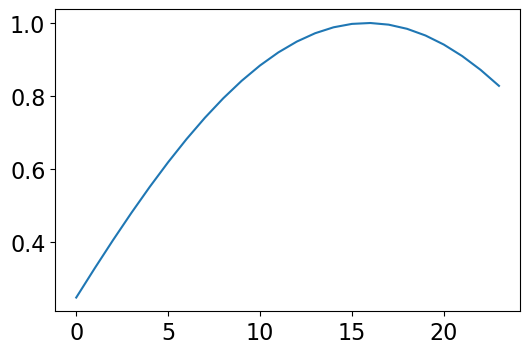

In [22]:
plt.plot(np.sin((big_ds.index.values + phase)/12))

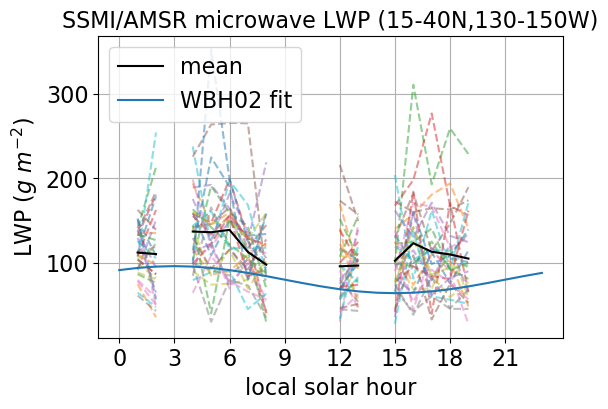

In [23]:
fig, ax = plt.subplots()
ax.plot(big_ds*1000, ls='--', alpha=0.5)
ax.plot(big_ds.mean(axis=1)*1000, c='k', label='mean')

a, mean, phase = 0.2, 80, 3
wood_fit = a*mean*np.sin(np.pi*(big_ds.index.values + phase)/12)+mean
plt.plot(big_ds.index.values, wood_fit, label='WBH02 fit')

ax.set_xticks(np.arange(0,24,3))
ax.set_xlabel('local solar hour')
ax.set_ylabel('LWP $(g\ m^{-2})$')
ax.grid(True)
ax.set_title('SSMI/AMSR microwave LWP (15-40N,130-150W)')
ax.legend()

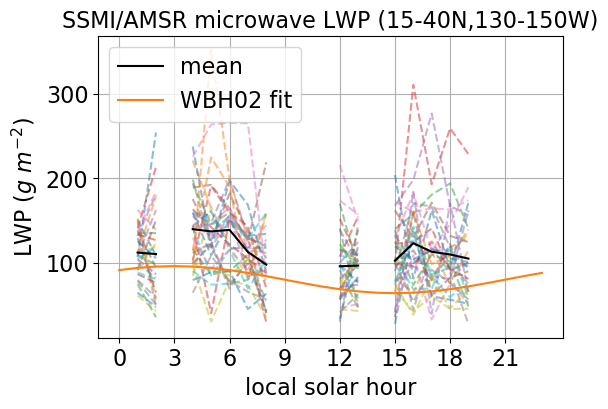

In [10]:
fig, ax = plt.subplots()
ax.plot(big_ds*1000, ls='--', alpha=0.5)
ax.plot(big_ds.mean(axis=1)*1000, c='k', label='mean')

a, mean, phase = 0.2, 80, 3
wood_fit = a*mean*np.sin(np.pi*(big_ds.index.values + phase)/12)+mean
plt.plot(big_ds.index.values, wood_fit, label='WBH02 fit')

ax.set_xticks(np.arange(0,24,3))
ax.set_xlabel('local solar hour')
ax.set_ylabel('LWP $(g\ m^{-2})$')
ax.grid(True)
ax.set_title('SSMI/AMSR microwave LWP (15-40N,130-150W)')
ax.legend()

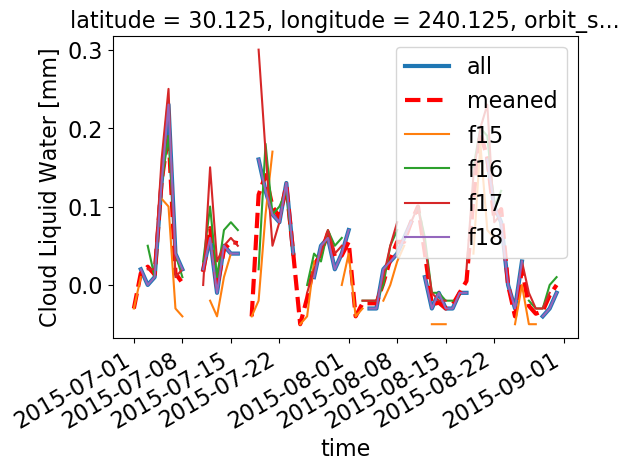

In [68]:
fig, ax = plt.subplots()
ssmi_data.cloud.sel(latitude=30, longitude=240, orbit_segment=0, method='nearest').plot(ax=ax, label='all', lw=3)
meaned.cloud.sel(latitude=30, longitude=240, orbit_segment=0, method='nearest').plot(ax=ax, label='meaned', c='r', lw=3, ls='--')

for sat,sd in sub_datas.items():
    sd.cloud.sel(latitude=30, longitude=240, orbit_segment=0, method='nearest').plot(ax=ax, label=sat)
ax.legend()

In [88]:
    ceres_file = xr.open_mfdataset('/home/disk/eos9/jkcm/Data/ceres/proc/split/CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.*.nc', combine='by_coords')


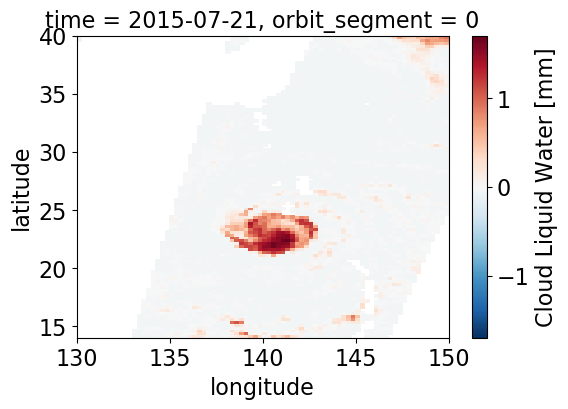

In [174]:
sample = all_data.isel(orbit_segment=0, time=20, sat=0).cloud.sel(latitude=slice(14,40), longitude=slice(130,150))
sample.plot()